### Setup

In [2]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Seaborn base theme
sns.set_theme(
    context="poster",  # 'paper' = smaller, for journal figures
    style="whitegrid",  # clean background with subtle grid
    font="DejaVu Sans",  # use a consistent sans-serif (replace if needed)
    font_scale=1.4,  # scale up text a bit for readability
    rc={
        # Figure sizing
        "figure.figsize": (10, 8),  # in inches; adjust for single-column
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.linewidth": 1.0,
        "axes.labelpad": 8,
        "axes.grid": True,
        "grid.linewidth": 0.4,
        "grid.alpha": 0.6,
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.frameon": False,
        "savefig.dpi": 300,
        "savefig.transparent": True,  # transparent background for vector exports
        "pdf.fonttype": 42,  # embed TrueType fonts (important for Illustrator)
        "ps.fonttype": 42,
    },
)

# Matplotlib tight layout by default
plt.rcParams.update({"figure.autolayout": True})

In [3]:
ANN_DATA_DIR = "../data/processed/anndata_combined"

human_adata = ad.read_h5ad("../data/processed/anndata_combined/human_combined.h5ad")
mouse_adata = ad.read_h5ad("../data/processed/anndata_combined/mouse_combined.h5ad")

N_SPLITS = 10

In [4]:
# ensure adatas have unique var names
human_adata.var_names_make_unique()
mouse_adata.var_names_make_unique()

# remove vars with NaN values
human_adata = human_adata[:, ~np.isnan(human_adata.X).any(axis=0)]
mouse_adata = mouse_adata[:, ~np.isnan(mouse_adata.X).any(axis=0)]

human_adata.obs["infl_acute"].fillna(False, inplace=True)
mouse_adata.obs["infl_acute"].fillna(False, inplace=True)
human_adata.obs["infl_acute"] = human_adata.obs["infl_acute"].astype(bool)
mouse_adata.obs["infl_acute"] = mouse_adata.obs["infl_acute"].astype(bool)

human_adata.obs["infl_subacute"].fillna(False, inplace=True)
mouse_adata.obs["infl_subacute"].fillna(False, inplace=True)
human_adata.obs["infl_subacute"] = human_adata.obs["infl_subacute"].astype(bool)
mouse_adata.obs["infl_subacute"] = mouse_adata.obs["infl_subacute"].astype(bool)

human_adata.obs["infl_chronic"].fillna(False, inplace=True)
mouse_adata.obs["infl_chronic"].fillna(False, inplace=True)
human_adata.obs["infl_chronic"] = human_adata.obs["infl_chronic"].astype(bool)
mouse_adata.obs["infl_chronic"] = mouse_adata.obs["infl_chronic"].astype(bool)

/tmp/ipykernel_1930303/2874002539.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  human_adata.obs['infl_acute'].fillna(False, inplace=True)
/tmp/ipykernel_1930303/2874002539.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [5]:
def transform_adata_to_X_y_all(adata):
    X = adata.X.copy()
    X_emb = adata.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata.obs["group"].map({"inflammation": 1, "control": 0}).values.astype(int)
    groups = adata.obs.get("dataset", pd.Series(np.zeros(len(adata)), index=adata.obs.index))
    return X, X_emb, y, groups


def transform_adata_to_X_y_takao(adata):
    adata_sub = adata[~adata.obs["takao_status"].isna()].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = (
        adata_sub.obs["takao_status"]
        .map({"takao_inflamed": 1, "takao_control": 0})
        .values.astype(int)
    )
    groups = adata_sub.obs.get(
        "dataset", pd.Series(np.zeros(len(adata_sub)), index=adata_sub.obs.index)
    )
    return X, X_emb, y, groups


def transform_adata_to_X_y_acute(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_acute"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_acute"].map({True: 1, False: 0}).values.astype(int)
    groups = adata_sub.obs.get(
        "dataset", pd.Series(np.zeros(len(adata_sub)), index=adata_sub.obs.index)
    )
    return X, X_emb, y, groups


def transform_adata_to_X_y_subacute(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_subacute"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_subacute"].map({True: 1, False: 0}).values.astype(int)
    groups = adata_sub.obs.get(
        "dataset", pd.Series(np.zeros(len(adata_sub)), index=adata_sub.obs.index)
    )
    return X, X_emb, y, groups


def transform_adata_to_X_y_acute_and_subacute(adata):
    adata_sub = adata[
        (adata.obs["group"] == "control")
        | (adata.obs["infl_acute"])
        | (adata.obs["infl_subacute"])
    ].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = (
        (adata_sub.obs["infl_acute"] | adata_sub.obs["infl_subacute"])
        .map({True: 1, False: 0})
        .values.astype(int)
    )
    groups = adata_sub.obs.get(
        "dataset", pd.Series(np.zeros(len(adata_sub)), index=adata_sub.obs.index)
    )
    return X, X_emb, y, groups


def transform_adata_to_X_y_chronic(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_chronic"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 1, False: 0}).values.astype(int)
    groups = adata_sub.obs.get(
        "dataset", pd.Series(np.zeros(len(adata_sub)), index=adata_sub.obs.index)
    )
    return X, X_emb, y, groups


def transform_adata_to_X_y_acute_to_chronic(adata):
    adata_sub = adata[(adata.obs["infl_acute"]) | (adata.obs["infl_chronic"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 0, False: 1}).values.astype(int)
    groups = adata_sub.obs.get(
        "dataset", pd.Series(np.zeros(len(adata_sub)), index=adata_sub.obs.index)
    )
    return X, X_emb, y, groups


def transform_adata_to_X_y_acute_subacute_to_chronic(adata):
    adata_sub = adata[
        (adata.obs["infl_acute"]) | (adata.obs["infl_subacute"]) | (adata.obs["infl_chronic"])
    ].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 0, False: 1}).values.astype(int)
    groups = adata_sub.obs.get(
        "dataset", pd.Series(np.zeros(len(adata_sub)), index=adata_sub.obs.index)
    )
    return X, X_emb, y, groups

### Define pipelines

In [6]:
def get_linear_pipelines():
    raw = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(solver="liblinear", random_state=21)),
        ]
    )
    embedding = Pipeline(
        [
            # ("scaler", StandardScaler()),
            ("clf", LogisticRegression(solver="liblinear", random_state=21)),
        ]
    )

    return {"Raw": raw, "Embedding": embedding}


def get_nonlinear_pipelines():
    raw = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler()),
            ("clf", SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=21)),
        ]
    )
    embedding = Pipeline(
        [
            # ("scaler", StandardScaler()),
            ("clf", SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=21)),
        ]
    )

    return {"Raw": raw, "Embedding": embedding}

### Evaluate within species performance

In [7]:
def evaluate_within_species(adata, setups, species_name, lodo_group_key="dataset", n_cv_folds=10):
    """
    Evaluates model performance within a single species using various methods.
    Stores ROC curves for all folds, so they can be plotted later.

    Args:
        adata (AnnData): AnnData object for the species.
        setups (list): List of tuples (setup_name, transform_func) returning X_raw, X_emb, y, groups.
        species_name (str): Name of the species (e.g., 'Human', 'Mouse').
        lodo_group_key (str): Column name in adata.obs for LODO groups.
        n_cv_folds (int): Number of folds for StratifiedKFold CV.

    Returns:
        tuple: (all_results, all_roc_data) dictionaries.
            all_roc_data contains lists of (fpr, tpr) tuples for each fold.
    """
    import numpy as np
    from tqdm import tqdm

    all_results = {
        "CrossValidation": {
            "Linear": {"Raw": {}, "Embedding": {}},
            "Nonlinear": {"Raw": {}, "Embedding": {}},
        },
        "LODO": {
            "Linear": {"Raw": {}, "Embedding": {}},
            "Nonlinear": {"Raw": {}, "Embedding": {}},
        },
    }
    all_roc_data = {
        "CrossValidation": {
            "Linear": {"Raw": {}, "Embedding": {}},
            "Nonlinear": {"Raw": {}, "Embedding": {}},
        },
        "LODO": {
            "Linear": {"Raw": {}, "Embedding": {}},
            "Nonlinear": {"Raw": {}, "Embedding": {}},
        },
    }

    for setup_name, transform_func in tqdm(setups, desc=f"Processing {species_name} setups"):
        tqdm.write(f"\n--- {species_name} - Setup: {setup_name} ---")
        try:
            X_raw, X_emb, y, groups = transform_func(adata)
            if len(np.unique(y)) < 2:
                tqdm.write(f"Skipping setup '{setup_name}': Only one class present.")
                continue
        except Exception as e:
            tqdm.write(f"Error transforming data for setup '{setup_name}': {e}")
            continue

        for model_type, pipeline_func in zip(
            ["Linear", "Nonlinear"], [get_linear_pipelines, get_nonlinear_pipelines]
        ):
            pipelines = pipeline_func()
            for data_type, X in [("Raw", X_raw), ("Embedding", X_emb)]:
                if X is None:
                    continue

                pipe_template = pipelines[data_type]
                full_key = setup_name

                # ---------------- Stratified K-Fold CV ----------------
                tqdm.write(f"  Running {n_cv_folds}-Fold CV ({model_type}, {data_type})...")
                try:
                    cv = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=42)
                    pipe_cv = clone(pipe_template)
                    cv_scores = cross_val_score(pipe_cv, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
                    all_results["CrossValidation"][model_type][data_type][full_key] = (
                        np.mean(cv_scores),
                        np.std(cv_scores),
                    )

                    # Store ROC for all folds
                    fold_roc_data = []
                    for train_idx, test_idx in cv.split(X, y):
                        if len(np.unique(y[test_idx])) < 2:
                            continue  # skip fold if test set has only one class
                        pipe_fold = clone(pipe_template).fit(X[train_idx], y[train_idx])
                        y_pred_fold = pipe_fold.predict_proba(X[test_idx])[:, 1]
                        fpr, tpr, _ = roc_curve(y[test_idx], y_pred_fold)
                        fold_roc_data.append((fpr, tpr))
                    all_roc_data["CrossValidation"][model_type][data_type][full_key] = (
                        fold_roc_data
                    )

                except Exception as e:
                    tqdm.write(f"  CV Error: {e}")
                    all_results["CrossValidation"][model_type][data_type][full_key] = (
                        np.nan,
                        np.nan,
                    )
                    all_roc_data["CrossValidation"][model_type][data_type][full_key] = []

                # ---------------- Leave-One-Group-Out CV ----------------
                tqdm.write(f"  Running LODO CV ({model_type}, {data_type})...")
                lodo_aurocs = []
                temp_roc_data_lodo = []
                logo = LeaveOneGroupOut()

                for train_idx, test_idx in logo.split(X, y, groups):
                    if len(np.unique(y[test_idx])) < 2:
                        continue  # skip fold if test set has only one class
                    try:
                        pipe = clone(pipe_template).fit(X[train_idx], y[train_idx])
                        y_pred = pipe.predict_proba(X[test_idx])[:, 1]
                        lodo_aurocs.append(roc_auc_score(y[test_idx], y_pred))
                        fpr, tpr, _ = roc_curve(y[test_idx], y_pred)
                        temp_roc_data_lodo.append((fpr, tpr))
                    except Exception:
                        continue

                if lodo_aurocs:
                    all_results["LODO"][model_type][data_type][full_key] = (
                        np.mean(lodo_aurocs),
                        np.std(lodo_aurocs),
                    )
                    all_roc_data["LODO"][model_type][data_type][full_key] = temp_roc_data_lodo
                else:
                    all_results["LODO"][model_type][data_type][full_key] = (np.nan, np.nan)
                    all_roc_data["LODO"][model_type][data_type][full_key] = []

    return all_results, all_roc_data

In [8]:
setups = [
    ("All Inflammation Samples vs. Control", transform_adata_to_X_y_all),
    ("Takao Subset for Inflammation vs. Control", transform_adata_to_X_y_takao),
    ("Acute Inflammation vs. Control", transform_adata_to_X_y_acute),
    ("Subacute Inflammation vs. Control", transform_adata_to_X_y_subacute),
    ("Chronic Inflammation vs. Control", transform_adata_to_X_y_chronic),
    ("Acute Inflammation vs. Chronic Inflammation", transform_adata_to_X_y_acute_to_chronic),
]

human_results, human_roc = evaluate_within_species(
    human_adata, setups, "Human", lodo_group_key="dataset"
)
mouse_results, mouse_roc = evaluate_within_species(
    mouse_adata, setups, "Mouse", lodo_group_key="dataset"
)

Processing Human setups:   0%|          | 0/6 [00:00<?, ?it/s]


--- Human - Setup: All Inflammation Samples vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Human setups:   0%|          | 0/6 [04:17<?, ?it/s]

  Running LODO CV (Linear, Raw)...


Processing Human setups:   0%|          | 0/6 [04:58<?, ?it/s]

  Running 10-Fold CV (Linear, Embedding)...


Processing Human setups:   0%|          | 0/6 [05:00<?, ?it/s]

  Running LODO CV (Linear, Embedding)...


Processing Human setups:   0%|          | 0/6 [05:00<?, ?it/s]

  Running 10-Fold CV (Nonlinear, Raw)...


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing Human setups:   0%|          | 0/6 [08:26<?, ?it/s]

  Running LODO CV (Nonlinear, Raw)...


Processing Human setups:   0%|          | 0/6 [09:03<?, ?it/s]

  Running 10-Fold CV (Nonlinear, Embedding)...


Processing Human setups:   0%|          | 0/6 [09:06<?, ?it/s]

  Running LODO CV (Nonlinear, Embedding)...


Processing Human setups:  17%|█▋        | 1/6 [09:07<45:35, 547.06s/it]


--- Human - Setup: Takao Subset for Inflammation vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Human setups:  17%|█▋        | 1/6 [10:26<45:35, 547.06s/it]

  Running LODO CV (Linear, Raw)...


Processing Human setups:  17%|█▋        | 1/6 [10:44<45:35, 547.06s/it]

  Running 10-Fold CV (Linear, Embedding)...


Processing Human setups:  17%|█▋        | 1/6 [10:45<45:35, 547.06s/it]

  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Human setups:  17%|█▋        | 1/6 [12:19<45:35, 547.06s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Human setups:  17%|█▋        | 1/6 [12:37<45:35, 547.06s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...


Processing Human setups:  17%|█▋        | 1/6 [12:39<45:35, 547.06s/it]

  Running LODO CV (Nonlinear, Embedding)...


Processing Human setups:  33%|███▎      | 2/6 [12:39<23:20, 350.24s/it]


--- Human - Setup: Acute Inflammation vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Human setups:  33%|███▎      | 2/6 [12:54<23:20, 350.24s/it]

  Running LODO CV (Linear, Raw)...


Processing Human setups:  33%|███▎      | 2/6 [12:57<23:20, 350.24s/it]

  Running 10-Fold CV (Linear, Embedding)...


Processing Human setups:  33%|███▎      | 2/6 [12:58<23:20, 350.24s/it]

  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Human setups:  33%|███▎      | 2/6 [13:31<23:20, 350.24s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Human setups:  33%|███▎      | 2/6 [13:34<23:20, 350.24s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...


Processing Human setups:  50%|█████     | 3/6 [13:35<10:47, 215.80s/it]

  Running LODO CV (Nonlinear, Embedding)...

--- Human - Setup: Subacute Inflammation vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Human setups:  50%|█████     | 3/6 [14:10<10:47, 215.80s/it]

  Running LODO CV (Linear, Raw)...


Processing Human setups:  50%|█████     | 3/6 [14:13<10:47, 215.80s/it]

  Running 10-Fold CV (Linear, Embedding)...


Processing Human setups:  50%|█████     | 3/6 [14:14<10:47, 215.80s/it]

  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Human setups:  50%|█████     | 3/6 [15:15<10:47, 215.80s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Human setups:  50%|█████     | 3/6 [15:21<10:47, 215.80s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...


Processing Human setups:  67%|██████▋   | 4/6 [15:22<05:45, 173.00s/it]

  Running LODO CV (Nonlinear, Embedding)...

--- Human - Setup: Chronic Inflammation vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Human setups:  67%|██████▋   | 4/6 [16:09<05:45, 173.00s/it]

  Running LODO CV (Linear, Raw)...


Processing Human setups:  67%|██████▋   | 4/6 [16:12<05:45, 173.00s/it]

  Running 10-Fold CV (Linear, Embedding)...


Processing Human setups:  67%|██████▋   | 4/6 [16:12<05:45, 173.00s/it]

  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Human setups:  67%|██████▋   | 4/6 [17:28<05:45, 173.00s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Human setups:  67%|██████▋   | 4/6 [17:35<05:45, 173.00s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...


Processing Human setups:  83%|████████▎ | 5/6 [17:37<02:39, 159.15s/it]

  Running LODO CV (Nonlinear, Embedding)...

--- Human - Setup: Acute Inflammation vs. Chronic Inflammation ---
  Running 10-Fold CV (Linear, Raw)...


Processing Human setups:  83%|████████▎ | 5/6 [18:25<02:39, 159.15s/it]

  Running LODO CV (Linear, Raw)...


Processing Human setups:  83%|████████▎ | 5/6 [18:30<02:39, 159.15s/it]

  Running 10-Fold CV (Linear, Embedding)...


Processing Human setups:  83%|████████▎ | 5/6 [18:31<02:39, 159.15s/it]

  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Human setups:  83%|████████▎ | 5/6 [22:09<02:39, 159.15s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Human setups:  83%|████████▎ | 5/6 [22:31<02:39, 159.15s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...


Processing Human setups:  83%|████████▎ | 5/6 [22:36<02:39, 159.15s/it]

  Running LODO CV (Nonlinear, Embedding)...


Processing Mouse setups:   0%|          | 0/6 [00:00<?, ?it/s]


--- Mouse - Setup: All Inflammation Samples vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Mouse setups:   0%|          | 0/6 [00:07<?, ?it/s]

  Running LODO CV (Linear, Raw)...


Processing Mouse setups:   0%|          | 0/6 [00:18<?, ?it/s]

  Running 10-Fold CV (Linear, Embedding)...


Processing Mouse setups:   0%|          | 0/6 [00:18<?, ?it/s]

  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Mouse setups:   0%|          | 0/6 [00:35<?, ?it/s]

  Running LODO CV (Nonlinear, Raw)...


Processing Mouse setups:   0%|          | 0/6 [00:40<?, ?it/s]

  Running 10-Fold CV (Nonlinear, Embedding)...


Processing Mouse setups:  17%|█▋        | 1/6 [00:40<03:23, 40.68s/it]

  Running LODO CV (Nonlinear, Embedding)...

--- Mouse - Setup: Takao Subset for Inflammation vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Mouse setups:  17%|█▋        | 1/6 [00:43<03:23, 40.68s/it]

  Running LODO CV (Linear, Raw)...


Processing Mouse setups:  17%|█▋        | 1/6 [00:44<03:23, 40.68s/it]

  Running 10-Fold CV (Linear, Embedding)...
  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Mouse setups:  17%|█▋        | 1/6 [00:49<03:23, 40.68s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Mouse setups:  33%|███▎      | 2/6 [00:50<01:30, 22.62s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...
  Running LODO CV (Nonlinear, Embedding)...

--- Mouse - Setup: Acute Inflammation vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Mouse setups:  33%|███▎      | 2/6 [00:53<01:30, 22.62s/it]

  Running LODO CV (Linear, Raw)...


Processing Mouse setups:  33%|███▎      | 2/6 [00:53<01:30, 22.62s/it]

  Running 10-Fold CV (Linear, Embedding)...
  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Mouse setups:  33%|███▎      | 2/6 [00:59<01:30, 22.62s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Mouse setups:  33%|███▎      | 2/6 [01:00<01:30, 22.62s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...
  Running LODO CV (Nonlinear, Embedding)...


Processing Mouse setups:  50%|█████     | 3/6 [01:00<00:50, 16.77s/it]


--- Mouse - Setup: Subacute Inflammation vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Mouse setups:  50%|█████     | 3/6 [01:03<00:50, 16.77s/it]

  Running LODO CV (Linear, Raw)...


Processing Mouse setups:  50%|█████     | 3/6 [01:05<00:50, 16.77s/it]

  Running 10-Fold CV (Linear, Embedding)...
  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Mouse setups:  50%|█████     | 3/6 [01:11<00:50, 16.77s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Mouse setups:  50%|█████     | 3/6 [01:13<00:50, 16.77s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...


Processing Mouse setups:  67%|██████▋   | 4/6 [01:13<00:30, 15.43s/it]

  Running LODO CV (Nonlinear, Embedding)...

--- Mouse - Setup: Chronic Inflammation vs. Control ---
  Running 10-Fold CV (Linear, Raw)...


Processing Mouse setups:  67%|██████▋   | 4/6 [01:17<00:30, 15.43s/it]

  Running LODO CV (Linear, Raw)...


Processing Mouse setups:  67%|██████▋   | 4/6 [01:18<00:30, 15.43s/it]

  Running 10-Fold CV (Linear, Embedding)...
  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Mouse setups:  67%|██████▋   | 4/6 [01:25<00:30, 15.43s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Mouse setups:  83%|████████▎ | 5/6 [01:26<00:14, 14.58s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...
  Running LODO CV (Nonlinear, Embedding)...

--- Mouse - Setup: Acute Inflammation vs. Chronic Inflammation ---
  Running 10-Fold CV (Linear, Raw)...


Processing Mouse setups:  83%|████████▎ | 5/6 [01:28<00:14, 14.58s/it]

  Running LODO CV (Linear, Raw)...
  Running 10-Fold CV (Linear, Embedding)...


Processing Mouse setups:  83%|████████▎ | 5/6 [01:28<00:14, 14.58s/it]

  Running LODO CV (Linear, Embedding)...
  Running 10-Fold CV (Nonlinear, Raw)...


Processing Mouse setups:  83%|████████▎ | 5/6 [01:31<00:14, 14.58s/it]

  Running LODO CV (Nonlinear, Raw)...


Processing Mouse setups: 100%|██████████| 6/6 [01:32<00:00, 15.36s/it]

  Running 10-Fold CV (Nonlinear, Embedding)...
  Running LODO CV (Nonlinear, Embedding)...


In [9]:
# save combined results
import pickle

combined_results = {"Human": (human_results, human_roc), "Mouse": (mouse_results, mouse_roc)}
with open("within_species_results.pkl", "wb") as f:
    pickle.dump(combined_results, f)

### Plotting functions

In [10]:
def plot_auroc_summary(all_results, model_type="Linear", setup_order=None):
    """
    Barplot summary of AUROC for CV and LODO across setups and data types.
    """
    data_types = ["Raw", "Embedding"]
    val_types = ["CrossValidation", "LODO"]
    colors = sns.color_palette("Set2", n_colors=2)
    hatches = ["//", ""]

    fig, ax = plt.subplots(figsize=(14, 8))
    width = 0.2
    x = np.arange(len(setup_order))

    for i, val_type in enumerate(val_types):
        for j, data_type in enumerate(data_types):
            heights, errs = [], []
            for setup in setup_order:
                mean_std = all_results[val_type][model_type][data_type].get(
                    setup, (np.nan, np.nan)
                )
                heights.append(mean_std[0])
                errs.append(mean_std[1])
            bars = ax.bar(
                x + (i * len(data_types) + j) * width,
                heights,
                width=width,
                yerr=errs,
                capsize=3,
                label=f"{val_type}-{data_type}",
                color=colors[j],
                hatch=hatches[i],
            )

    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(setup_order, rotation=0, ha="right", fontsize=8)
    ax.set_ylabel("AUROC")
    ax.set_ylim(0, 1.19)
    ax.axhline(0.5, color="k", linestyle="--", alpha=0.3, linewidth=0.8)

    for i, tick in enumerate(ax.xaxis.get_major_ticks()):
        if i % 2 != 0:  # Select every other tick (starting from the second)
            tick.set_pad(15)  # Increase padding to move it down

    for label in ax.get_xticklabels():
        label.set_horizontalalignment("center")

    # Move legend outside
    ax.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_cv_roc(all_roc_data, model_type="Linear", setup_order=None):
    """
    Plot CV ROC curves for each setup (2x3 grid, all lines shown).
    """
    data_types = ["Raw", "Embedding"]
    colors = sns.color_palette("Set2", n_colors=2)

    fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, setup in zip(axes, setup_order):
        for data_type, color in zip(data_types, colors):
            roc_list = all_roc_data["CrossValidation"][model_type][data_type].get(setup, [])
            if not roc_list:
                continue
            for fpr, tpr in roc_list:
                ax.plot(fpr, tpr, color=color, alpha=0.5, lw=1)
        ax.plot([0, 1], [0, 1], "k--", lw=0.8, alpha=0.4)
        ax.set_title(setup, fontsize=9)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

    # Only label outer axes
    for i, ax in enumerate(axes):
        if i // 3 == 1:  # bottom row
            ax.set_xlabel("FPR")
            ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            ax.set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        else:
            ax.set_xticklabels([])
        if i % 3 == 0:  # left column
            ax.set_ylabel("TPR")
            ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        else:
            ax.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_lodo_roc(all_roc_data, model_type="Linear", setup_order=None):
    """
    Plot LODO ROC curves for each setup (2x3 grid, all lines shown).
    """
    data_types = ["Raw", "Embedding"]
    colors = sns.color_palette("Set2", n_colors=2)

    fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, setup in zip(axes, setup_order):
        for data_type, color in zip(data_types, colors):
            roc_list = all_roc_data["LODO"][model_type][data_type].get(setup, [])
            if not roc_list:
                continue
            for fpr, tpr in roc_list:
                ax.plot(fpr, tpr, color=color, alpha=0.5, lw=1)
        ax.plot([0, 1], [0, 1], "k--", lw=0.8, alpha=0.4)
        ax.set_title(setup, fontsize=9)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

    # Only label outer axes
    for i, ax in enumerate(axes):
        if i // 3 == 1:
            ax.set_xlabel("FPR")
        else:
            ax.set_xticklabels([])
        if i % 3 == 0:
            ax.set_ylabel("TPR")
        else:
            ax.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_all(species, model):
    setup_order = [
        "All Inflammation Samples vs. Control",
        "Takao Subset for Inflammation vs. Control",
        "Acute Inflammation vs. Control",
        "Subacute Inflammation vs. Control",
        "Chronic Inflammation vs. Control",
        "Acute Inflammation vs. Chronic Inflammation",
    ]
    all_results, all_roc_data = combined_results[species]

    # Figure 1: AUROC summary
    plot_auroc_summary(all_results, model_type=model, setup_order=setup_order)

    # # Figure 2: CV ROC curves
    # plot_cv_roc(all_roc_data, model_type=model, setup_order=setup_order)

    # # Figure 3: LODO ROC curves
    # plot_lodo_roc(all_roc_data, model_type=model, setup_order=setup_order)

### Human - linear model

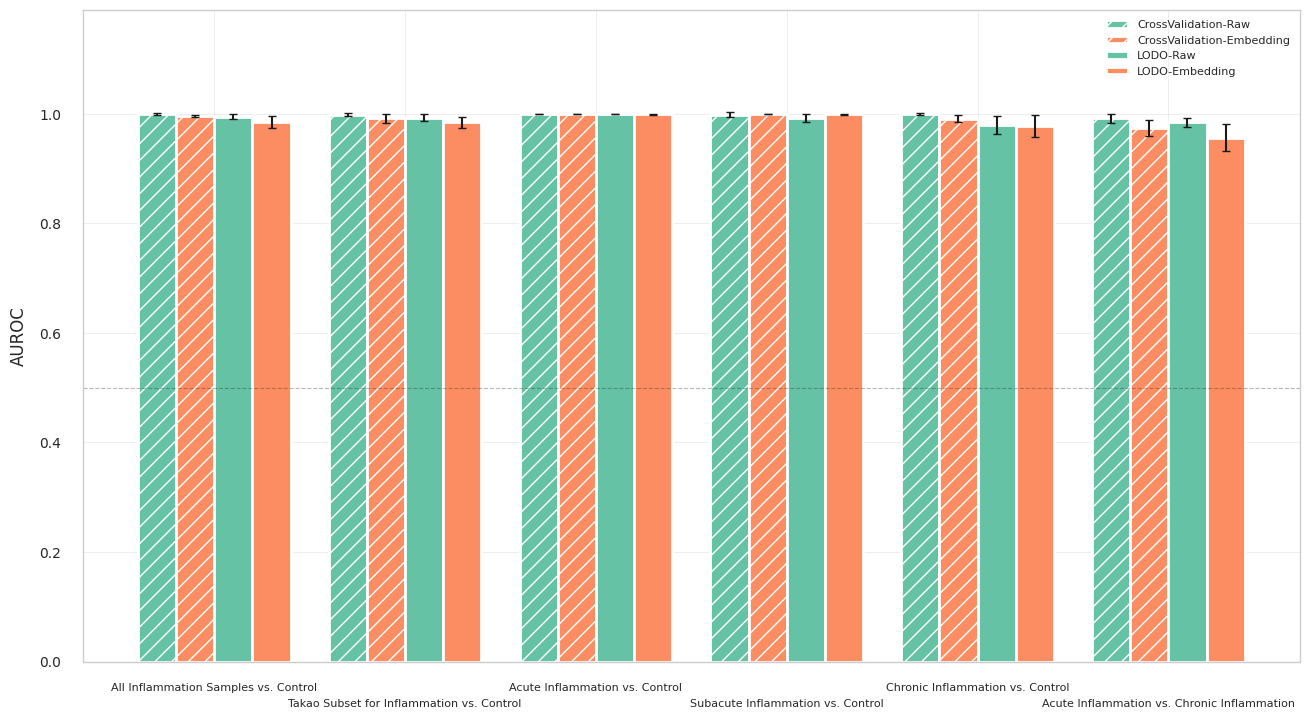

In [11]:
plot_all("Human", "Linear")

### Mouse - linear model

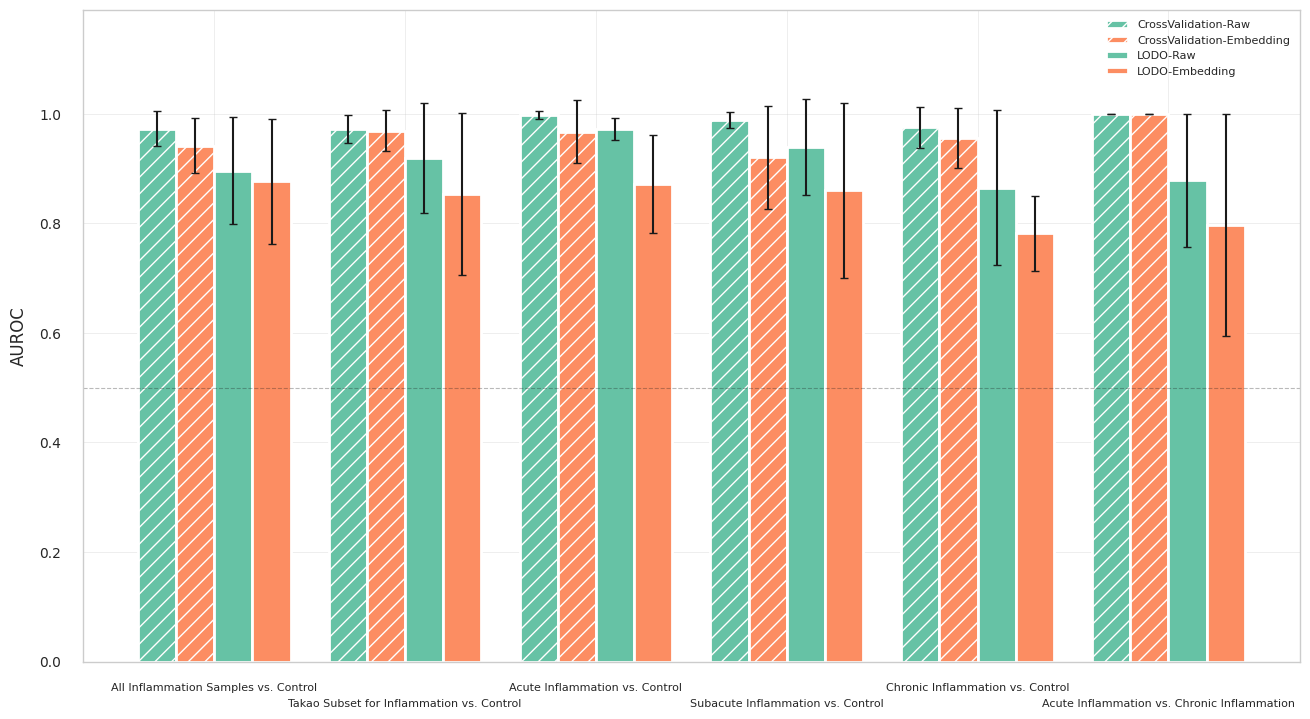

In [12]:
plot_all("Mouse", "Linear")

### Human - Nonlinear model

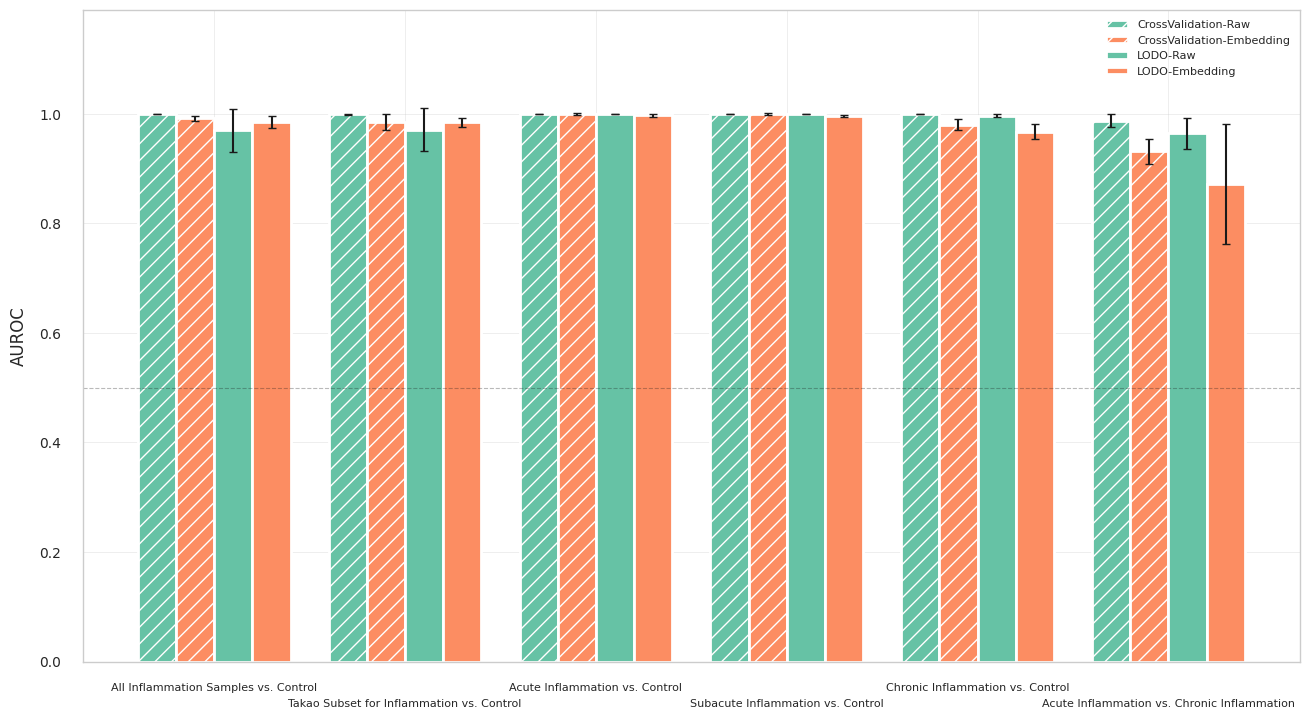

In [13]:
plot_all("Human", "Nonlinear")

### Mouse - Nonlinear model

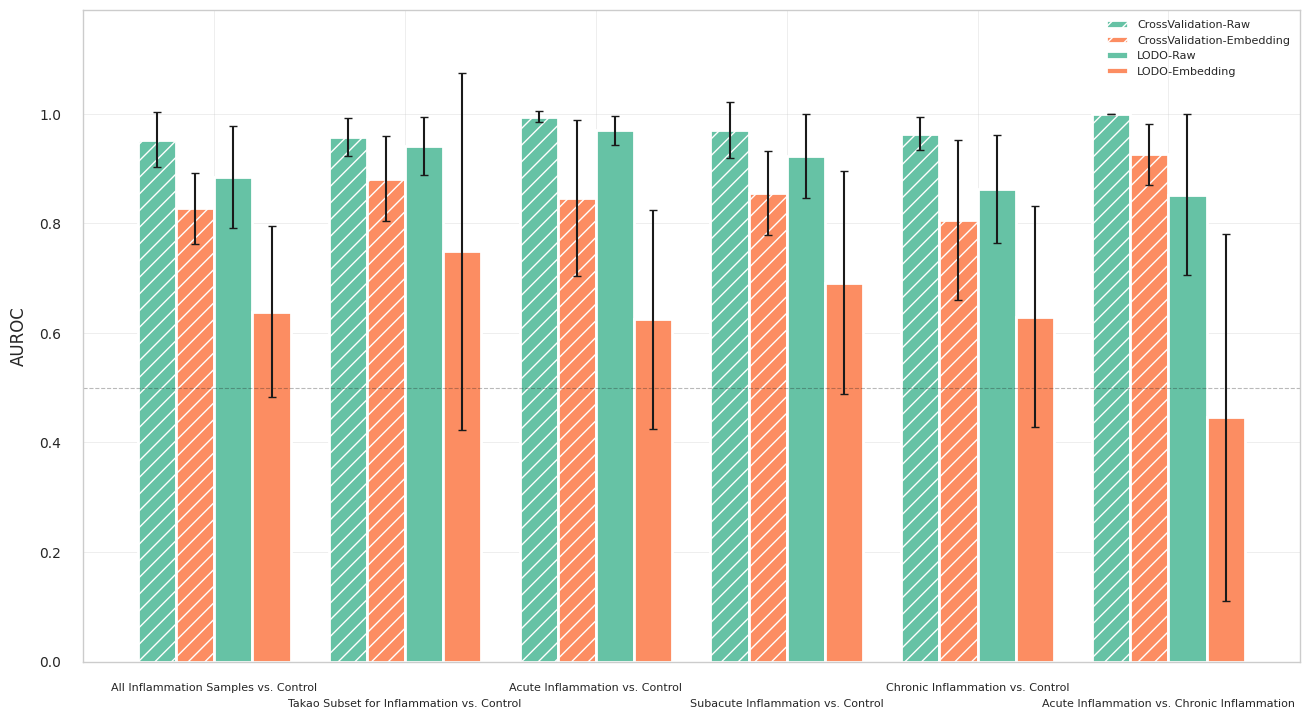

In [14]:
plot_all("Mouse", "Nonlinear")